# Generative Adversarial Networks 
### Week-10
### Case-1

### Demonstration how to generate images of handwritten digits (like MNIST dataset) using
### a Deep Convolutional Generative Adversarial Network (DCGAN)

[source](https://arxiv.org/pdf/1511.06434.pdf)

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

##### (GANs) can be described as models which are trained simultaneously by an adversarial process. 
A *generator* learns to create images that look real, while a *discriminator* learns to tell real images apart from fakes.
During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

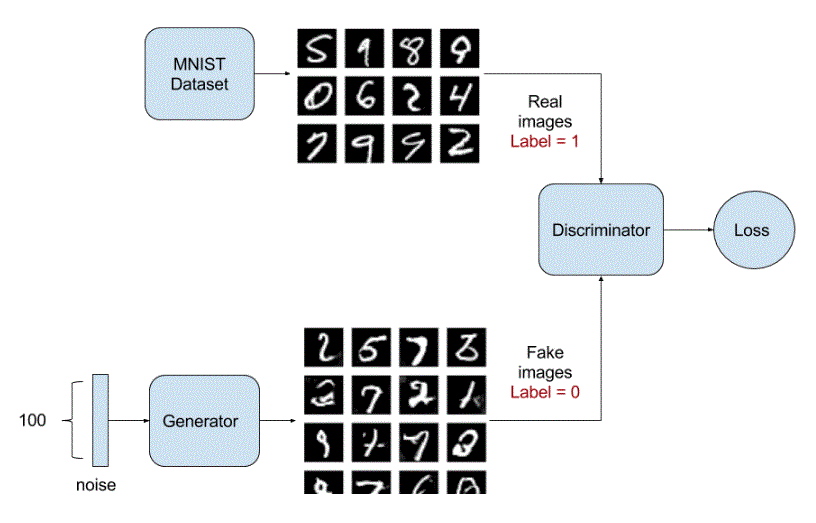

##### This notebook uses on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

### Import 

image.png


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

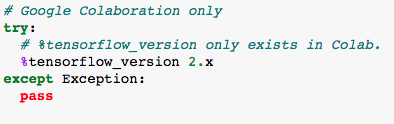

In [2]:
try:
    %tensorflow_version 2.x

except Exception:
    pass

image.png

In [3]:
import tensorflow as tf

image.png

In [4]:
tf.__version__

'2.13.0'

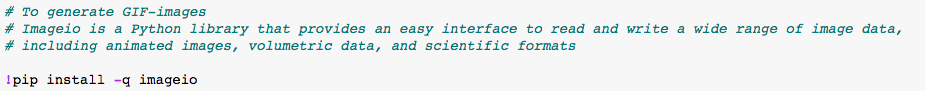

In [5]:
pip install -q imageio

Note: you may need to restart the kernel to use updated packages.


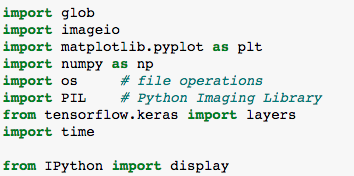


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display


### MNIST Dataset
After treining the generator will generate handwritten digits resembling the MNIST data.


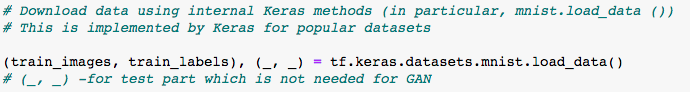

In [6]:
(train_images, train_labels), (_, _) = tf. keras.datasets.mnist.load_data()

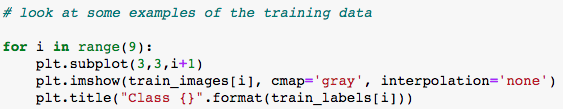

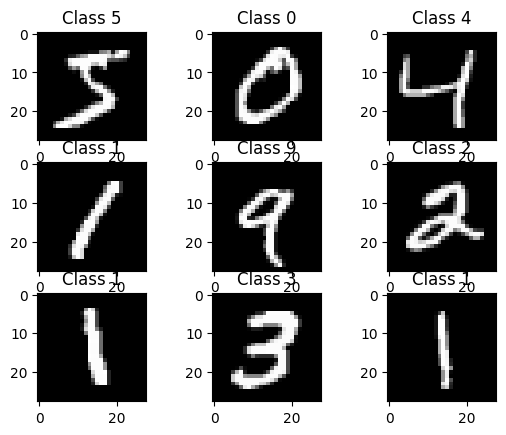

In [7]:
for i in range(9):
    plt.subplot (3,3, i+1)
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title( "Class {}". format(train_labels[i]))

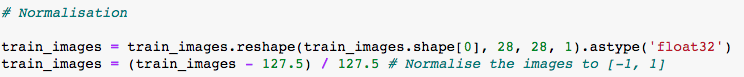

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

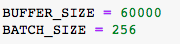

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

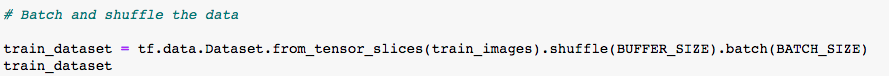

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

2024-03-09 22:22:46.304170: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-09 22:22:46.304316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-09 22:22:46.304374: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-09 22:22:46.304666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-09 22:22:46.304881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

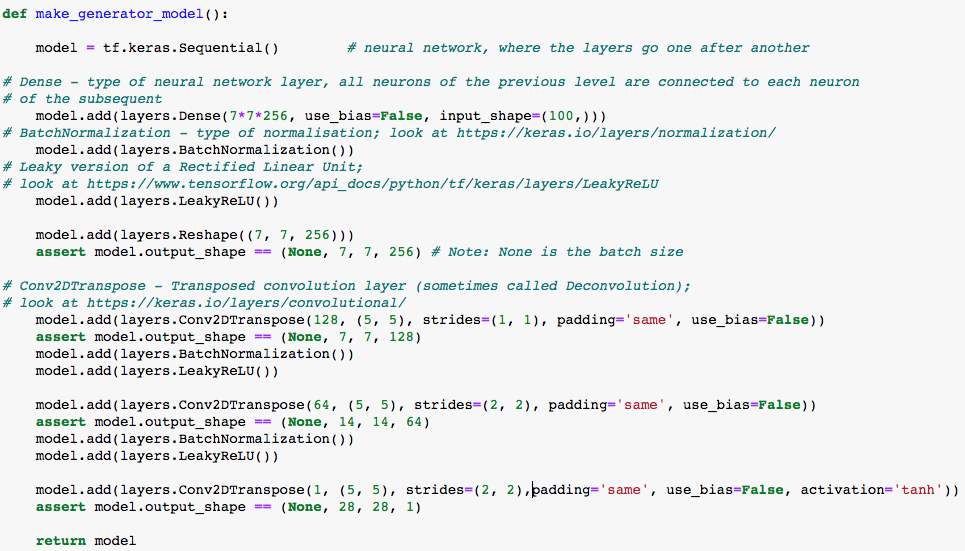


In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Conv2DTranspose (64, (5, 5), strides=(2, 2), padding='same', use_bias=False) )
    assert model. output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add (layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),padding='same', use_bias=False, activation='tanh'))
    assert model,output_shape == (None, 28, 28, 1)
    return model

Use the generator to create an image.


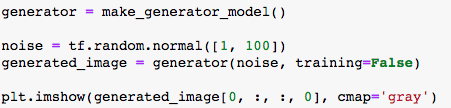



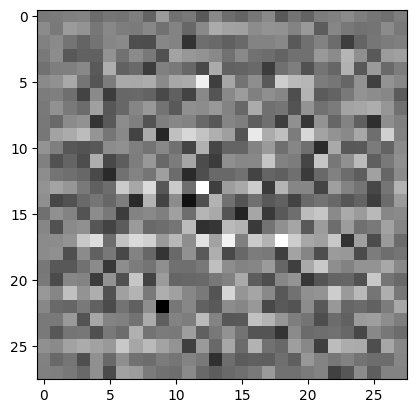

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

image.png



In [15]:
generator?

Signature:      generator(*args, **kwargs)
Type:           Sequential
String form:    <keras.src.engine.sequential.Sequential object at 0x310de7910>
File:           ~/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/sequential.py
Docstring:     
`Sequential` groups a linear stack of layers into a `tf.keras.Model`.

`Sequential` provides training and inference features on this model.

Examples:

```python
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
# Afterwards, we do automatic shape inference:
model.add(tf.keras.layers.Dense(4))

# This is identical to the following:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(8))

# Note that you can also omit the `input_shape` argument.
# In that case the model doesn't have any weights until the first call
# to a training/evaluation method (since it isn't yet built):
m

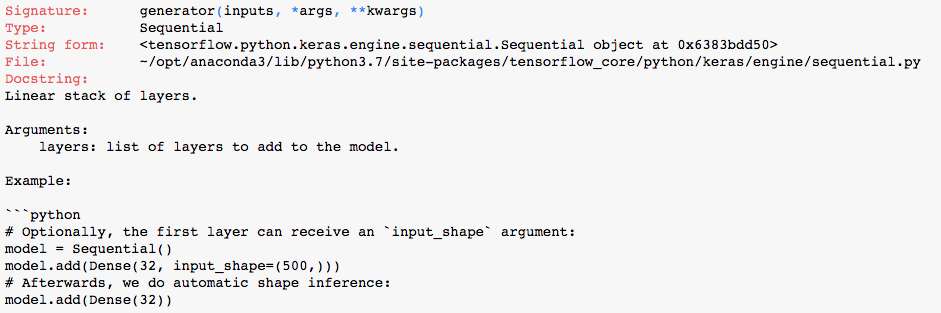


In [ ]:
# Describe why the image does not have a structure?

### The Discriminator

The discriminator is a CNN-based image classifier.

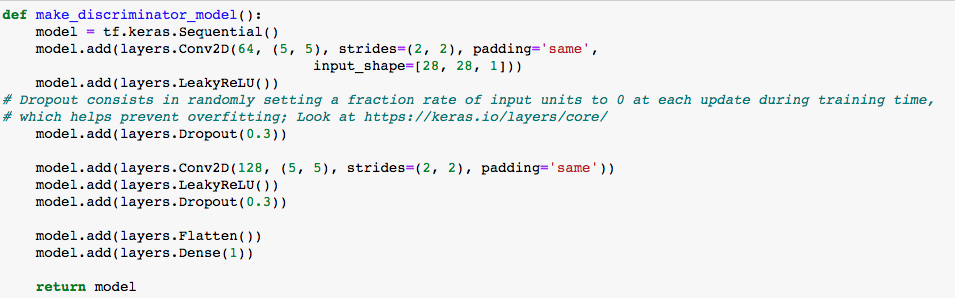

In [13]:
def make_discriminator_model() :
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())

    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
    model.add(layers .LeakyReLU())
    model.add(layers. Dropout (0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense (1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

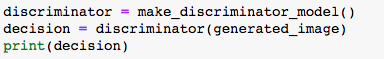

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00148275]], shape=(1, 1), dtype=float32)


image.png

In [20]:
discriminator?

Signature:      discriminator(*args, **kwargs)
Type:           Sequential
String form:    <keras.src.engine.sequential.Sequential object at 0x3105dbc10>
File:           ~/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/sequential.py
Docstring:     
`Sequential` groups a linear stack of layers into a `tf.keras.Model`.

`Sequential` provides training and inference features on this model.

Examples:

```python
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
# Afterwards, we do automatic shape inference:
model.add(tf.keras.layers.Dense(4))

# This is identical to the following:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(8))

# Note that you can also omit the `input_shape` argument.
# In that case the model doesn't have any weights until the first call
# to a training/evaluation method (since it isn't yet built

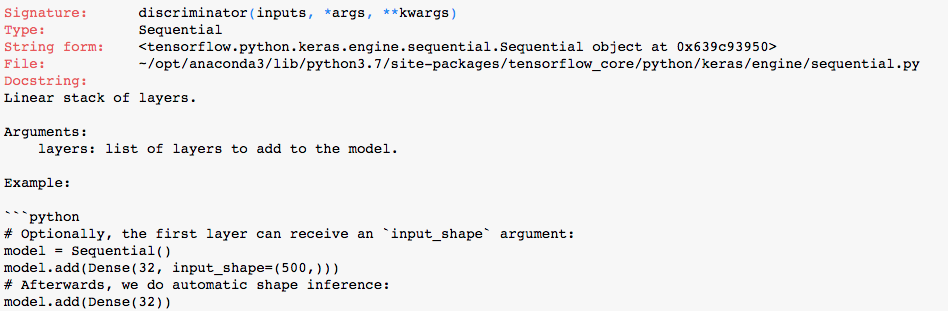

## Define the loss and optimizers

Define loss functions and optimizers for both models.


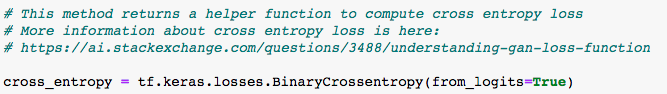

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

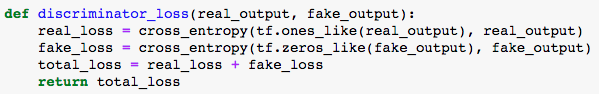

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

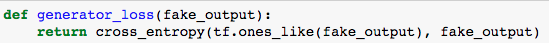

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

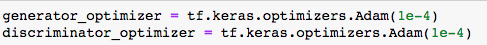

In [18]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

image.png

In [26]:
tf.keras.optimizers.legacy.Adam?

Init signature:
tf.keras.optimizers.legacy.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
    **kwargs,
)
Docstring:     
Optimizer that implements the Adam algorithm.

Adam optimization is a stochastic gradient descent method that is based on
adaptive estimation of first-order and second-order moments.

According to
[Kingma et al., 2014](http://arxiv.org/abs/1412.6980),
the method is "*computationally
efficient, has little memory requirement, invariant to diagonal rescaling of
gradients, and is well suited for problems that are large in terms of
data/parameters*".

Args:
  learning_rate: A `Tensor`, floating point value, or a schedule that is a
    `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
    that takes no arguments and returns the actual value to use, The
    learning rate. Defaults to `0.001`.
  beta_1: A float value or a constant float tensor, or a callable
    that takes no argument

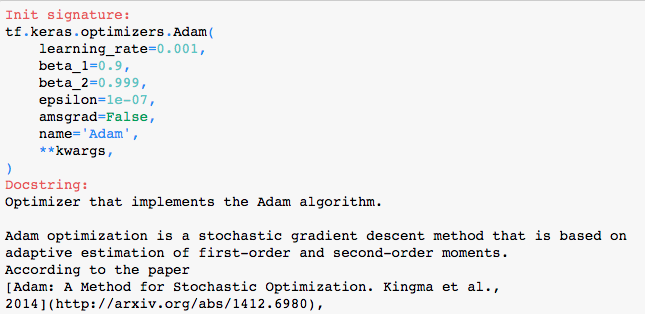


### Save checkpoints
It is useful in case a long running training task is interrupted.


image.png

In [27]:
tf.train.Checkpoint?

Init signature: tf.train.Checkpoint(root=None, **kwargs)
Docstring:     
Manages saving/restoring trackable values to disk.

TensorFlow objects may contain trackable state, such as `tf.Variable`s,
`tf.keras.optimizers.Optimizer` implementations, `tf.data.Dataset` iterators,
`tf.keras.Layer` implementations, or  `tf.keras.Model` implementations.
These are called **trackable objects**.

A `Checkpoint` object can be constructed to save either a single or group of
trackable objects to a checkpoint file. It maintains a `save_counter` for
numbering checkpoints.

Example:

```python
model = tf.keras.Model(...)
checkpoint = tf.train.Checkpoint(model)

# Save a checkpoint to /tmp/training_checkpoints-{save_counter}. Every time
# checkpoint.save is called, the save counter is increased.
save_path = checkpoint.save('/tmp/training_checkpoints')

# Restore the checkpointed values to the `model` object.
checkpoint.restore(save_path)
```

Example 2:

```python
import tensorflow as tf
import os

check

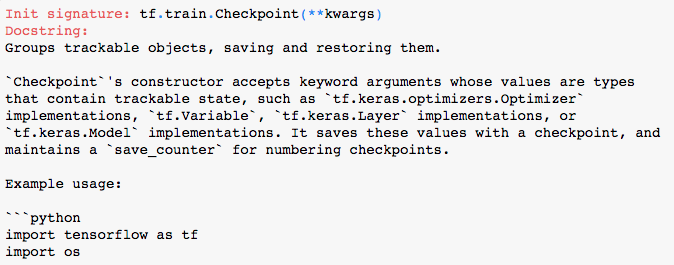

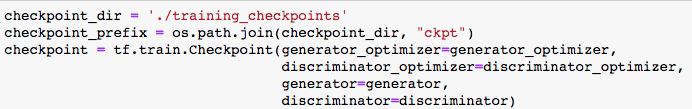

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer= discriminator_optimizer,
                                 generator = generator,discriminator = discriminator)

## Training loop



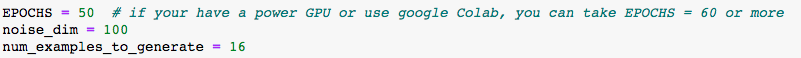


In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

image.png

In [30]:
tf.random.normal?

Signature:
tf.random.normal(
    shape,
    mean=0.0,
    stddev=1.0,
    dtype=tf.float32,
    seed=None,
    name=None,
)
Docstring:
Outputs random values from a normal distribution.

Example that generates a new set of random values every time:

>>> tf.random.set_seed(5);
>>> tf.random.normal([4], 0, 1, tf.float32)
<tf.Tensor: shape=(4,), dtype=float32, numpy=..., dtype=float32)>

Example that outputs a reproducible result:

>>> tf.random.set_seed(5);
>>> tf.random.normal([2,2], 0, 1, tf.float32, seed=1)
<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.3768897 , -0.01258316],
      [-0.169515   ,  1.0824056 ]], dtype=float32)>

In this case, we are setting both the global and operation-level seed to
ensure this result is reproducible.  See `tf.random.set_seed` for more
information.

Args:
  shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
  mean: A Tensor or Python value of type `dtype`, broadcastable with `stddev`.
    The mean of the normal di

In [ ]:
tf.random.normal?

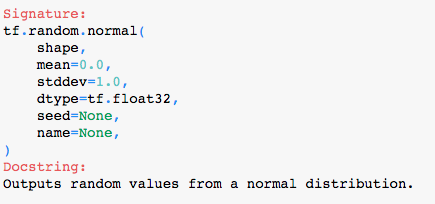

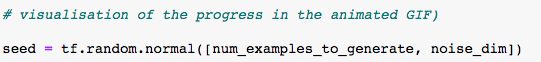

In [21]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

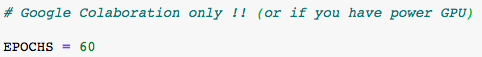

In [22]:
Epochs = 60

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

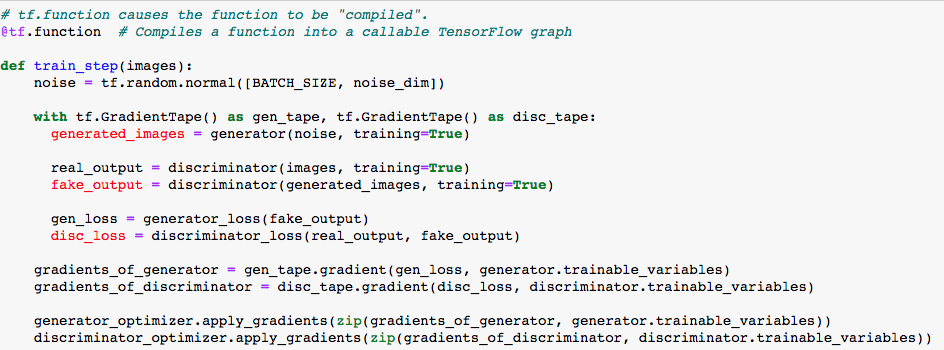

In [23]:
@tf.function

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training= True)
        
        real_output = discriminator (images, training=True)
        fake_output = discriminator (generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

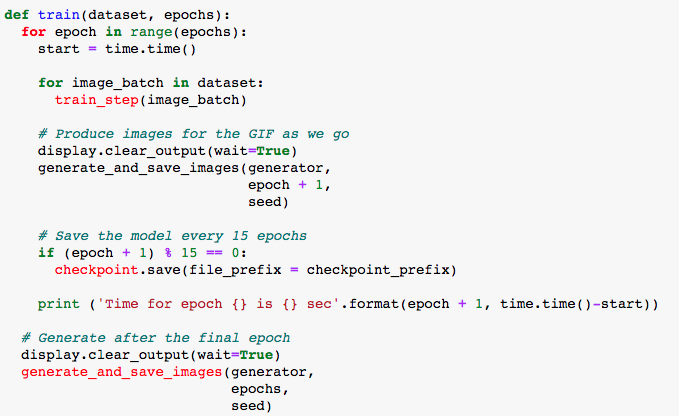

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step (image_batch)

        display.clear_output (wait=True)
        generate_and_save_images (generator, epoch +1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**Generate and save images**



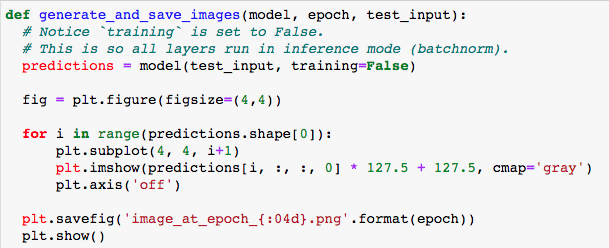

In [25]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}•png'.format(epoch))
    plt.show()

## Train the model
train() - training the generator and discriminator simultaneously. 
It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

In [ ]:
# Save your Jupyter Notebook before start the next cell

image.png

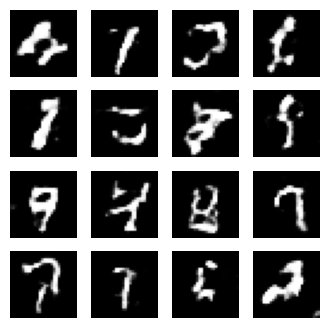

In [26]:
train(train_dataset, 60)

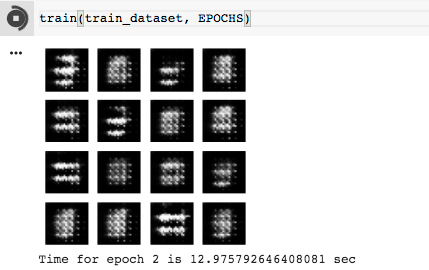

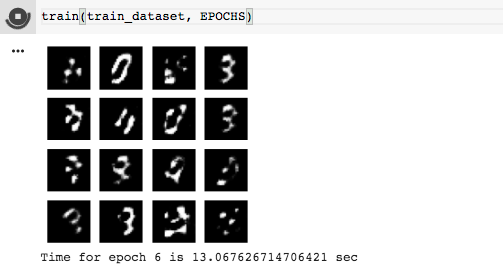

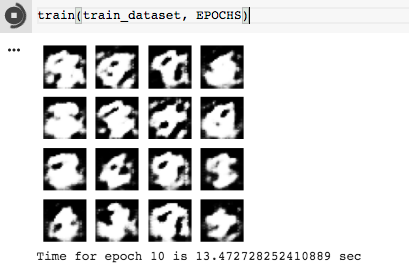

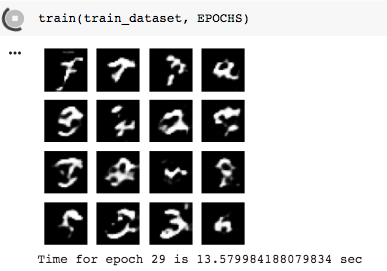

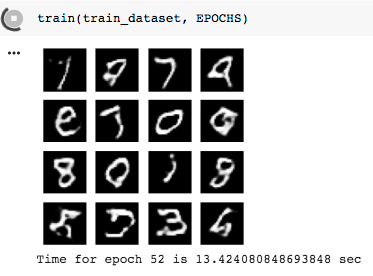

Restore the latest checkpoint.

image.png

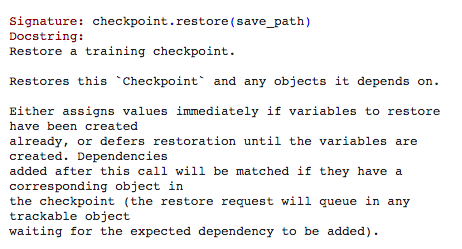

image.png

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Show the result as a GIF-file


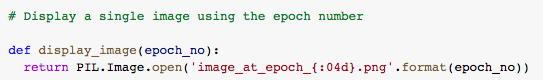

In [28]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}•png.png'.format(epoch_no))

image.png

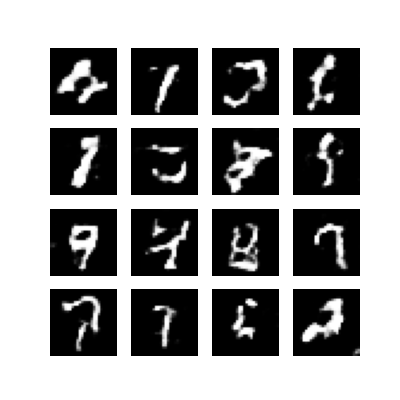

In [37]:
display_image(60)

In [ ]:
# describe the results

Use `imageio` to create an animated gif using the images saved during training.

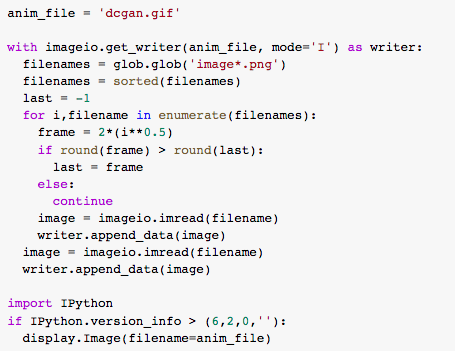

In [30]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)


/var/folders/pl/tqnpqw0d0lg1qyvvvs2sk2kr0000gn/T/ipykernel_21533/79645492.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/pl/tqnpqw0d0lg1qyvvvs2sk2kr0000gn/T/ipykernel_21533/79645492.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


/var/folders/pl/tqnpqw0d0lg1qyvvvs2sk2kr0000gn/T/ipykernel_21533/2972929786.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/pl/tqnpqw0d0lg1qyvvvs2sk2kr0000gn/T/ipykernel_21533/2972929786.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


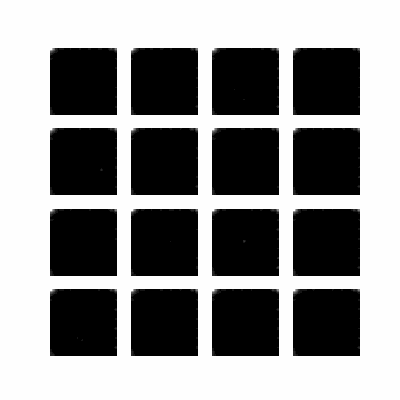

In [44]:
import imageio
import glob
from IPython.display import display
from IPython.display import Image as DisplayImage  # Aliasing to prevent name conflict


anim_file = 'dcgan.gif'

# Create the GIF file with loop=0 for infinite looping
with imageio.get_writer(anim_file, mode='I', loop=0) as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        # The following line repeats the append operation; it may be intentional for doubling the frame rate.
        image = imageio.imread(filename)
        writer.append_data(image)

# Assuming 'anim_file' is the path to your GIF file
display(DisplayImage(filename=anim_file, embed=True))


In [39]:
from IPython.display import Image

If you're working in Colab you can download the animation with the code below:

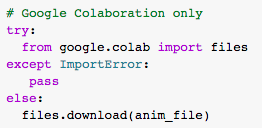

In [82]:
# Google Colaboration only
try:
    from google.colab import files
except ImportError:
    pass
else:
    files. download (anim_file)

source:
[Introducing TF-GAN: A lightweight GAN library for TensorFlow 2.0](https://medium.com/tensorflow/introducing-tf-gan-a-lightweight-gan-library-for-tensorflow-2-0-36d767e1abae)